In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

In [13]:
# 1. 加载数据并清理非数值列
def load_and_clean_data(files):
    dataframes = []
    for file in files:
        df = pd.read_csv(file)
        
        # 删除非数值列和 `ts_code` 列
        if 'ts_code' in df.columns:
            df.drop(columns=['ts_code'], inplace=True)
        
        # 转换 `trade_date` 列为日期格式并设为索引
        df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
        df.set_index('trade_date', inplace=True)
        
        # 处理缺失值
        df.fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)
        
        dataframes.append(df)
    return dataframes

files = ['data/000001.SZ.csv', 'data/000002.SZ.csv', 'data/000063.SZ.csv']
dataframes = load_and_clean_data(files)


C:\Users\86134\AppData\Local\Temp\ipykernel_22668\4223895612.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\86134\AppData\Local\Temp\ipykernel_22668\4223895612.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\86134\AppData\Local\Temp\ipykernel_22668\4223895612.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [14]:
# 2. 数据预处理和缩放到-1到1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dataframes = [pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index) for df in dataframes]


In [17]:
# 3. 制作数据集 (今天的收盘价预测明天的收盘价)
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length, :-1]
        y = self.data[index+self.sequence_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 30
train_datasets = [StockDataset(df.values, sequence_length) for df in scaled_dataframes]
train_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in train_datasets]


In [18]:
# 4. 构建Transformer模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward,
                                          dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = self.fc_out(x[:, -1, :])  # use the last time step
        return x

input_size = dataframes[0].shape[1] - 1
model = TransformerModel(input_size)


In [19]:
# 5. 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
# 6. 模型训练
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

def train_model(model, train_loaders, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for loader in train_loaders:
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                predictions = model(x).squeeze()
                loss = loss_fn(predictions, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loaders)}")

train_model(model, train_loaders, epochs=10)


Epoch 1, Loss: 4.35958035197109
Epoch 2, Loss: 0.8920877921239784
Epoch 3, Loss: 0.6324121603587022
Epoch 4, Loss: 0.5192086024520298
Epoch 5, Loss: 0.4344776715540017
Epoch 6, Loss: 0.3602189878001809
Epoch 7, Loss: 0.3603132280210654
Epoch 8, Loss: 0.2964832125968921
Epoch 9, Loss: 0.28690106798118603
Epoch 10, Loss: 0.280947031142811


In [26]:
# 7. 保存模型参数
model_save_path = r'transformer_stock_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model parameters saved to {model_save_path}")


Model parameters saved to D:\aprogram\program_study\python\pycharm\jupyter\gupiao\pythonProject\transformer_stock_model.pth


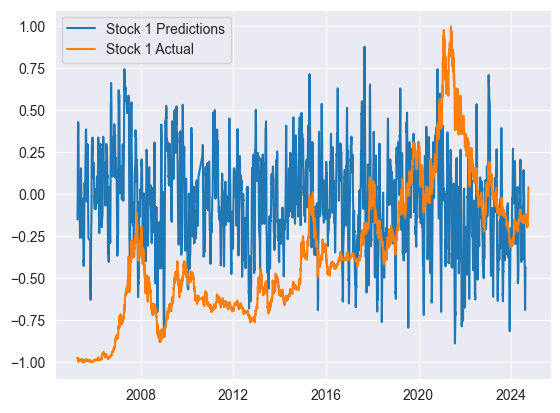

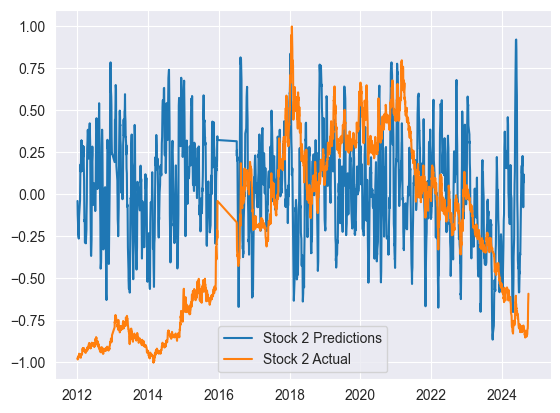

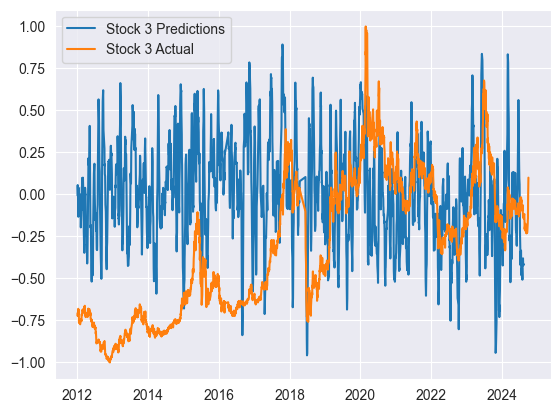

In [27]:
# 8. 预测与可视化
def predict(model, data):
    model.eval()
    predictions = []
    for i in range(len(data) - sequence_length):
        x = torch.tensor(data[i:i+sequence_length, :-1], dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            predictions.append(model(x).item())
    return predictions

for i, df in enumerate(scaled_dataframes):
    predictions = predict(model, df.values)
    plt.plot(df.index[sequence_length:], predictions, label=f'Stock {i+1} Predictions')
    plt.plot(df.index, df['close_qfq'], label=f'Stock {i+1} Actual')
    plt.legend()
    plt.show()

In [33]:
# 加载模型参数
model_load_path = 'transformer_stock_model.pth'
model = TransformerModel(input_size)
model.load_state_dict(torch.load(model_load_path))
model = model.to(device)
model.eval()
print(f"Model loaded from {model_load_path}")


Model loaded from transformer_stock_model.pth


C:\Users\86134\AppData\Local\Temp\ipykernel_22668\2969674914.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
